In [1]:
from Definiciones import *
import pandas as pd

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

def initialize():
    train_data = pd.read_csv('Data/DMC_Train.csv', header=0)
    test_data = pd.read_csv('Data/DMC_Test.csv', header=0)

    numeric_coerce = train_data.select_dtypes(include=["object"]).drop(["csa"], axis=1).columns

    train_data[numeric_coerce] = train_data[numeric_coerce].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    test_data[numeric_coerce] = test_data[numeric_coerce].apply(lambda x: pd.to_numeric(x, errors='coerce'))

    float_coerce = train_data.select_dtypes(include=["int64"]).columns
    float_coerce = [x for x in float_coerce if x not in ['churn', 'customer']]
    train_data[float_coerce] = train_data[float_coerce].astype(float)
    test_data[float_coerce] = test_data[float_coerce].astype(float)
    
    return train_data, test_data

train_data, test_data = initialize()
target_var = "churn"
predictors = [x for x in test_data.columns.tolist() if x not in ['customer', 'csa']]

descriptors = ['incmiss', 'income', 'marryno', 'marryun', 'marryyes', 
               'occcler', 'occcrft', 'occhmkr', 'occprof', 'occret', 
               'occself', 'occstud', 'ownrent', 'prizmrur', 'prizmtwn', 
               'prizmub', 'credita', 'creditaa', 'creditb', 'creditc', 
               'creditcd', 'creditde', 'creditgy', 'creditz', 'mcycle', 
               'pcown', 'rv', 'travel', 'truck']

business_vars = ['changem', 'changer', 'directas', 'mou', 'overage', 
                 'recchrge', 'roam', 'revenue', 'eqpdays', 'models', 
                 'phones', 'actvsubs', 'blckvce', 'callfwdv', 'callwait', 
                 'custcare', 'dropblk', 'dropvce', 'incalls', 'mailflag', 
                 'mailord', 'mailres', 'months', 'mourec', 'newcelln', 
                 'newcelly', 'opeakvce', 'outcalls', 'peakvce', 'refer', 
                 'refurb', 'retaccpt', 'retcall', 'retcalls', 'setprc', 
                 'setprcm', 'threeway', 'unansvce', 'uniqsubs', 'webcap']

C:\Users\Kenji\Anaconda2\envs\python3\lib\site-packages\IPython\core\interactiveshell.py:2809: DtypeWarning: Columns (1,2,3,4,5,6,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [2]:
#Creación de variables

def variable_creation(df):
    df["change_missing"] = df["changem"].isnull().astype(float)
    df["missing_mean_info"] = df["revenue"].isnull().astype(float)
    df["actvsubs_missing"] = (df["actvsubs"] == 0).astype(float)
    df.loc[df['actvsubs_missing'] == 1, "actvsubs"] = np.NaN
    df["age1_is_null"] = ((df["age1"].isnull()) | (df["age1"] == 0)).astype(float)
    df["age2_is_null"] = ((df['age2'].isnull()) | ((df['age2'] == 0) & (df['actvsubs'] > 1))).astype(float)
    df.loc[df["age1_is_null"] == 1, "age1"] = np.NaN
    df.loc[df["age2_is_null"] == 1, "age2"] = np.NaN
    return df

train_data = variable_creation(train_data)
test_data = variable_creation(test_data)

predictors_with_new_vars = predictors + ["change_missing", "missing_mean_info", "age1_is_null", "age2_is_null", "actvsubs_missing"]

In [3]:
#Imputación
from sklearn.preprocessing import Imputer

continuous_vars = ["changem", "changer", "directas", "mou", "overage", "recchrge", "roam", "revenue"]
train_data[continuous_vars], test_data[continuous_vars] = \
    impute_train_test(train_data[continuous_vars], test_data[continuous_vars])

discrete_vars = ["age1", "age2", "eqpdays", "models", "phones", "actvsubs"]
train_data[discrete_vars], test_data[discrete_vars] = \
    impute_train_test(train_data[discrete_vars], test_data[discrete_vars], is_discrete=True)

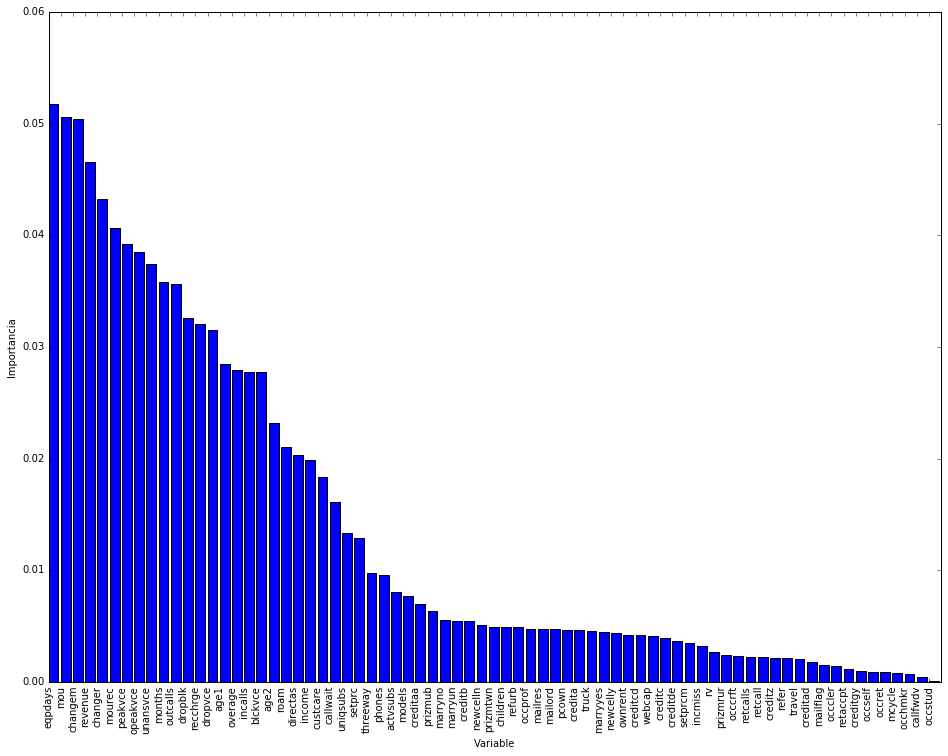

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

# Perform feature selection
#selector = SelectKBest(f_classif, k='all')
#selector.fit(train_data[predictors], train_data[target_var])
selector = RandomForestClassifier(n_estimators = 100, max_features= 'auto', min_samples_leaf = 2, n_jobs=-2)
selector.fit(train_data[predictors], train_data[target_var])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = selector.feature_importances_

values = sorted(zip(predictors, scores), key=(lambda x: x[1]), reverse=True)

plt.bar(range(len([x[0] for x in values])), [x[1] for x in values])
plt.xlim([0, len(values)])
plt.xlabel('Variable')
plt.ylabel('Importancia')
plt.xticks(range(len([x[0] for x in values])), [x[0] for x in values], rotation='vertical')

plt.show()

In [14]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.decomposition import PCA

params = [
          [{'rfc__min_samples_split': [1] + list(np.logspace(1, 9, 5, base=2).astype('int')), 
            'rfc__min_samples_leaf': [1] + list(np.logspace(2, 5, 4, base=2).astype('int')),
            'rfc__max_features': ['auto', 0.3, 0.4],
            'rfc__class_weight': [None, 'balanced']}], #random forest
          [{'abc__learning_rate': [0.7, 0.8, 0.9]}],
          [{'gbc__learning_rate': [0.02, 0.05, 0.1],
            'gbc__min_samples_split': [1] + list(np.logspace(1, 9, 5, base=2).astype('int')),
            'gbc__min_samples_leaf': [1] + list(np.logspace(2, 5, 4, base=2).astype('int')),
            'gbc__max_features': ['auto', 0.3, 0.4]}]
         ]

classifiers = [
               [('rfc', RandomForestClassifier(n_estimators = 100, random_state=1))],
               [('abc', AdaBoostClassifier(n_estimators = 100, random_state=1))],
               [('gbc', GradientBoostingClassifier(n_estimators = 100, random_state=1))]
              ]

preliminary_steps = []

grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                             classifiers, params, preliminary_steps, 
                             scoring='roc_auc',
                             cv=StratifiedShuffleSplit(train_data[target_var], n_iter=4, test_size=0.1),
                             n_jobs=-2,
                             verbose=1)

Now testing rfc
Preparing to fit
Fitting 4 folds for each of 180 candidates, totalling 720 fits


[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed: 35.9min
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed: 56.4min
[Parallel(n_jobs=-2)]: Done 720 out of 720 | elapsed: 65.4min finished


Fitting completed
Best parameters set found on development set:
{'rfc__class_weight': None, 'rfc__min_samples_split': 128, 'rfc__max_features': 0.4, 'rfc__min_samples_leaf': 16}
Best score set found on development set:
0.667650343643
Grid scores on development set:

0.636 (+/-0.040) for {'rfc__class_weight': None, 'rfc__min_samples_split': 1, 'rfc__max_features': 'auto', 'rfc__min_samples_leaf': 1}
0.606 (+/-0.038) for {'rfc__class_weight': None, 'rfc__min_samples_split': 2, 'rfc__max_features': 'auto', 'rfc__min_samples_leaf': 1}
0.631 (+/-0.042) for {'rfc__class_weight': None, 'rfc__min_samples_split': 8, 'rfc__max_features': 'auto', 'rfc__min_samples_leaf': 1}
0.603 (+/-0.071) for {'rfc__class_weight': None, 'rfc__min_samples_split': 32, 'rfc__max_features': 'auto', 'rfc__min_samples_leaf': 1}
0.604 (+/-0.025) for {'rfc__class_weight': None, 'rfc__min_samples_split': 128, 'rfc__max_features': 'auto', 'rfc__min_samples_leaf': 1}
0.619 (+/-0.023) for {'rfc__class_weight': None, 'rfc__

[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:   36.5s finished


Fitting completed
Best parameters set found on development set:
{'abc__learning_rate': 0.8}
Best score set found on development set:
0.649158075601
Grid scores on development set:

0.642 (+/-0.043) for {'abc__learning_rate': 0.7}
0.649 (+/-0.034) for {'abc__learning_rate': 0.8}
0.627 (+/-0.029) for {'abc__learning_rate': 0.9}

Now testing gbc
Preparing to fit
Fitting 4 folds for each of 270 candidates, totalling 1080 fits


[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-2)]: Done 999 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-2)]: Done 1080 out of 1080 | elapsed: 54.3min finished


Fitting completed
Best parameters set found on development set:
{'gbc__max_features': 0.3, 'gbc__learning_rate': 0.1, 'gbc__min_samples_split': 32, 'gbc__min_samples_leaf': 16}
Best score set found on development set:
0.665069265464
Grid scores on development set:

0.656 (+/-0.036) for {'gbc__max_features': 'auto', 'gbc__learning_rate': 0.02, 'gbc__min_samples_split': 1, 'gbc__min_samples_leaf': 1}
0.628 (+/-0.023) for {'gbc__max_features': 'auto', 'gbc__learning_rate': 0.02, 'gbc__min_samples_split': 2, 'gbc__min_samples_leaf': 1}
0.646 (+/-0.049) for {'gbc__max_features': 'auto', 'gbc__learning_rate': 0.02, 'gbc__min_samples_split': 8, 'gbc__min_samples_leaf': 1}
0.605 (+/-0.035) for {'gbc__max_features': 'auto', 'gbc__learning_rate': 0.02, 'gbc__min_samples_split': 32, 'gbc__min_samples_leaf': 1}
0.636 (+/-0.057) for {'gbc__max_features': 'auto', 'gbc__learning_rate': 0.02, 'gbc__min_samples_split': 128, 'gbc__min_samples_leaf': 1}
0.603 (+/-0.007) for {'gbc__max_features': 'auto', 

In [24]:
classifiers = [
               [('rfc', RandomForestClassifier(n_estimators = 100, random_state = 42))],
               [('abc', AdaBoostClassifier(n_estimators = 100, random_state = 42))],
               [('gbc', GradientBoostingClassifier(n_estimators = 100, random_state = 42))],
              ]

params = [
          [{'rfc__class_weight': [None], 'rfc__min_samples_split': [128], 'rfc__max_features': [0.4], 'rfc__min_samples_leaf': [16]}], #Random Forest
          [{'abc__learning_rate': [0.8]}], #AdaBoost
          [{'gbc__max_features': [0.3], 'gbc__learning_rate': [0.1], 'gbc__min_samples_split': [32], 'gbc__min_samples_leaf': [16]}]  #Gradient Boosting
         ]

preliminary_steps = []

grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                     algorithms=classifiers, parameters=params, preliminary_steps=preliminary_steps,
                     cv=StratifiedShuffleSplit(train_data[target_var], n_iter=6, test_size=0.2),
                     n_jobs=-2,
                     verbose=1)

Now testing rfc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:   56.0s finished


Fitting completed
Best parameters set found on development set:
{'rfc__class_weight': None, 'rfc__min_samples_split': 128, 'rfc__max_features': 0.4, 'rfc__min_samples_leaf': 16}
Best score set found on development set:
0.635960364762
Grid scores on development set:

0.636 (+/-0.026) for {'rfc__class_weight': None, 'rfc__min_samples_split': 128, 'rfc__max_features': 0.4, 'rfc__min_samples_leaf': 16}

Now testing abc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:   21.6s finished


Fitting completed
Best parameters set found on development set:
{'abc__learning_rate': 0.8}
Best score set found on development set:
0.624673047322
Grid scores on development set:

0.625 (+/-0.029) for {'abc__learning_rate': 0.8}

Now testing gbc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:   14.8s finished


Fitting completed
Best parameters set found on development set:
{'gbc__max_features': 0.3, 'gbc__learning_rate': 0.1, 'gbc__min_samples_split': 32, 'gbc__min_samples_leaf': 16}
Best score set found on development set:
0.634163087056
Grid scores on development set:

0.634 (+/-0.032) for {'gbc__max_features': 0.3, 'gbc__learning_rate': 0.1, 'gbc__min_samples_split': 32, 'gbc__min_samples_leaf': 16}



In [26]:
#parámetros del mejor classifier

classifiers = [
               ('rfc', RandomForestClassifier(n_estimators = 100, 
                                              random_state = 42, 
                                              class_weight = 'balanced', 
                                              min_samples_split=128, 
                                              min_samples_leaf=16)),
               ('abc', AdaBoostClassifier(n_estimators = 100, 
                                          random_state = 42, 
                                          learning_rate= 0.8)),
               ('gbc', GradientBoostingClassifier(n_estimators = 100, 
                                                  random_state = 42, 
                                                  max_features=0.3, 
                                                  min_samples_split=32, 
                                                  min_samples_leaf=16)),
              ]

params = [{'vtc__voting': ['soft']}]
preliminary_steps = []

clf = VotingClassifier(estimators=classifiers)
grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                     algorithms=[[('vtc', clf)]], parameters=params, preliminary_steps=preliminary_steps,
                     cv=StratifiedShuffleSplit(train_data[target_var], n_iter=6, test_size=0.2),
                     n_jobs=-2,
                     verbose=1)

Now testing vtc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:   40.2s finished


Fitting completed
Best parameters set found on development set:
{'vtc__voting': 'soft'}
Best score set found on development set:
0.637209604095
Grid scores on development set:

0.637 (+/-0.031) for {'vtc__voting': 'soft'}



In [41]:
#Reiniciar

train_data, test_data = initialize()
target_var = "churn"
predictors = [x for x in test_data.columns.tolist() if x not in ['customer', 'csa']]

train_data = variable_creation(train_data)
test_data = variable_creation(test_data)

predictors_with_new_vars = predictors + ["change_missing", "missing_mean_info", "age1_is_null", "age2_is_null", "actvsubs_missing"]

encode_categorical(train_data)
encode_categorical(test_data)

C:\Users\Kenji\Anaconda2\envs\python3\lib\site-packages\IPython\core\interactiveshell.py:2809: DtypeWarning: Columns (1,2,3,4,5,6,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\Kenji\Anaconda2\envs\python3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [68]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import Normalizer

total_clusters = 4
excluded_columns = ['customer', 'csa', 'churn']
non_null_predictors = [x for x in train_data.dropna(axis='columns').columns.tolist() if x not in excluded_columns]
train_data, mbkm = add_cluster_feature(train_data, non_null_predictors, total_clusters)
test_data, _ = add_cluster_feature(test_data, non_null_predictors, total_clusters, mbkm)
#print(train_data.shape)
for i in range(total_clusters):
    print("Cluster", i, ":", (train_data['cluster'] == i).sum())
    print("Churn:", train_data[train_data.cluster == i].churn.sum())

Cluster 0 : 11195
Churn: 282
Cluster 1 : 11002
Churn: 454
Cluster 2 : 7556
Churn: 160
Cluster 3 : 10247
Churn: 304


In [70]:
#Imputación por clusters

from sklearn.preprocessing import Imputer

continuous_vars = ["changem", "changer", "directas", "mou", "overage", "recchrge", "roam", "revenue"]
discrete_vars = ["age1", "age2", "eqpdays", "models", "phones", "actvsubs"]
    
for cc in range(total_clusters):
    train_data.loc[train_data.cluster == cc, continuous_vars], test_data.loc[test_data.cluster == cc, continuous_vars] = \
        impute_train_test(train_data.loc[train_data.cluster == cc, continuous_vars], test_data.loc[test_data.cluster == cc, continuous_vars])

    train_data.loc[train_data.cluster == cc, discrete_vars], test_data.loc[test_data.cluster == cc, discrete_vars] = \
        impute_train_test(train_data.loc[train_data.cluster == cc, discrete_vars], test_data.loc[test_data.cluster == cc, discrete_vars], is_discrete=True)

In [81]:
#Reiniciar

train_data, test_data = initialize()
target_var = "churn"
predictors = [x for x in test_data.columns.tolist() if x not in ['customer', 'csa']]

train_data = variable_creation(train_data)
test_data = variable_creation(test_data)

train_data = variable_creation(train_data)
test_data = variable_creation(test_data)

predictors_with_new_vars = predictors + ["change_missing", "missing_mean_info", "age1_is_null", "age2_is_null", "actvsubs_missing"]

C:\Users\Kenji\Anaconda2\envs\python3\lib\site-packages\IPython\core\interactiveshell.py:2809: DtypeWarning: Columns (1,2,3,4,5,6,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [82]:
#Imputación por regresor

from sklearn.ensemble import AdaBoostRegressor

non_null_predictors = [x for x in train_data.dropna(axis='columns').columns.tolist() if x not in ['customer', 'csa', 'churn']]
continuous_vars = ["changem", "changer", "directas", "mou", "overage", "recchrge", "roam", "revenue"]
discrete_vars = ["age1", "age2", "eqpdays", "models", "phones", "actvsubs"]

for current_target in continuous_vars + discrete_vars:
    print("Estimating for feature:", current_target)
    abc = AdaBoostRegressor(n_estimators = 100)
    
    X_train, Y_train = train_data[train_data[current_target].notnull()][non_null_predictors],\
                       train_data[train_data[current_target].notnull()][current_target]
    abc.fit(X_train, Y_train)
    
    X_target = train_data[train_data[current_target].isnull()][non_null_predictors]
    predictions = abc.predict(X_target)
    if current_target in continuous_vars:
        train_data.loc[train_data[current_target].isnull(), current_target] = predictions
    else:
        train_data.loc[train_data[current_target].isnull(), current_target] = predictions.astype(int)
    
    X_test = test_data[test_data[current_target].isnull()][non_null_predictors]
    if (X_test.shape[0] == 0):
        continue
        
    test_predictions = abc.predict(X_test)
    if current_target in continuous_vars:
        test_data.loc[test_data[current_target].isnull(), current_target] = test_predictions
    else:
        test_data.loc[test_data[current_target].isnull(), current_target] = test_predictions.astype(int)

Estimating for feature: changem
Estimating for feature: changer
Estimating for feature: directas
Estimating for feature: mou
Estimating for feature: overage
Estimating for feature: recchrge
Estimating for feature: roam
Estimating for feature: revenue
Estimating for feature: age1
Estimating for feature: age2
Estimating for feature: eqpdays
Estimating for feature: models
Estimating for feature: phones
Estimating for feature: actvsubs


In [85]:
#Imputación por regresor

clf = VotingClassifier(estimators=classifiers)
grids = grid_search_multiple(train_data[predictors], train_data[target_var], 
                     algorithms=[[('vtc', clf)]], parameters=params, preliminary_steps=preliminary_steps,
                     cv=StratifiedShuffleSplit(train_data[target_var], n_iter=6, test_size=0.2),
                     n_jobs=-2,
                     verbose=1)

Now testing vtc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:   40.3s finished


Fitting completed
Best parameters set found on development set:
{'vtc__voting': 'soft'}
Best score set found on development set:
0.633434815292
Grid scores on development set:

0.633 (+/-0.028) for {'vtc__voting': 'soft'}



In [87]:
#Age ratio calculation

train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age_ratio'] = \
    train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age1'] - train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age2']
train_data.loc[(train_data['age2'] == 0) | (train_data['age1'] != 0), 'age_ratio'] = 0
test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age_ratio'] = \
    test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age1'] / test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age2']
test_data.loc[(test_data['age2'] == 0) | (test_data['age1'] != 0), 'age_ratio'] = 0
predictors = predictors + ['age_ratio']

#train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age_difference'] = \
#    train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age1'] / train_data.loc[(train_data['age2'] != 0) & (train_data['age1'] != 0), 'age2']
#train_data.loc[(train_data['age2'] == 0) | (train_data['age1'] != 0), 'age_difference'] = 0
#test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age_difference'] = \
#    test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age1'] - test_data.loc[(test_data['age2'] != 0) & (test_data['age1'] != 0), 'age2']
#test_data.loc[(test_data['age2'] == 0) | (test_data['age1'] != 0), 'age_difference'] = 0
#predictors = predictors + ['age_difference']

In [86]:
#Probar con variables creadas

clf = VotingClassifier(estimators=classifiers)
grids = grid_search_multiple(train_data[predictors_with_new_vars + ["age_ratio"]], train_data[target_var], 
                     algorithms=[[('vtc', clf)]], parameters=params, preliminary_steps=preliminary_steps,
                     cv=StratifiedShuffleSplit(train_data[target_var], n_iter=6, test_size=0.2),
                     n_jobs=-2,
                     verbose=1)

Now testing vtc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:   40.8s finished


Fitting completed
Best parameters set found on development set:
{'vtc__voting': 'soft'}
Best score set found on development set:
0.616564110825
Grid scores on development set:

0.617 (+/-0.029) for {'vtc__voting': 'soft'}



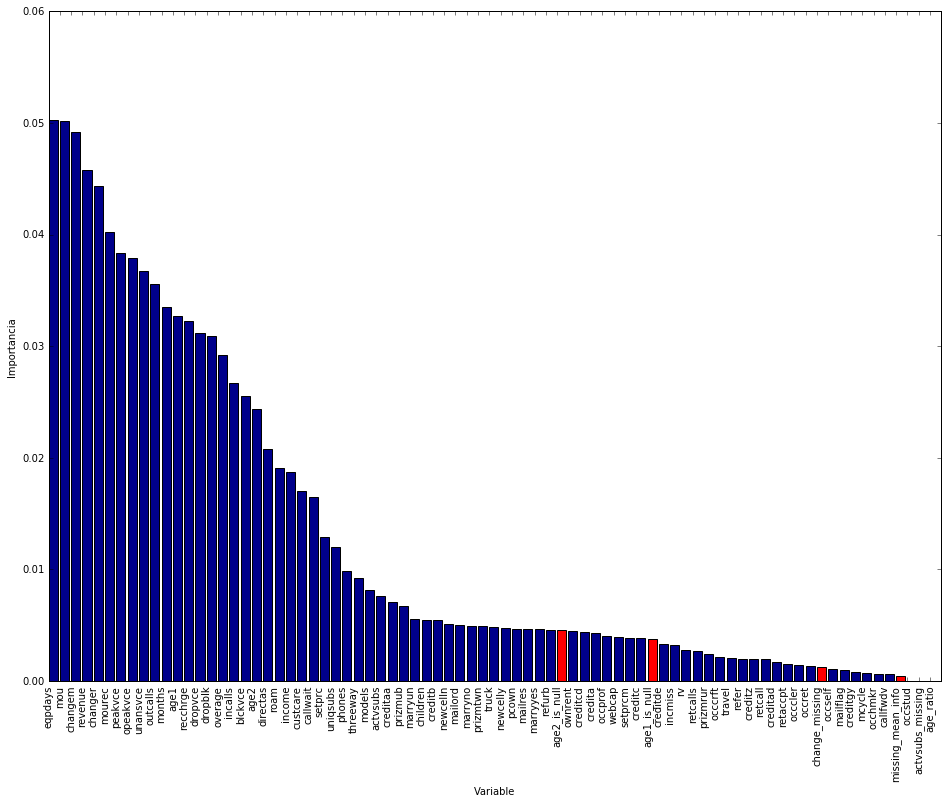

In [99]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

# Perform feature selection
#selector = SelectKBest(f_classif, k='all')
#selector.fit(train_data[predictors], train_data[target_var])
selector = RandomForestClassifier(n_estimators = 100, max_features= 'auto', min_samples_leaf = 2, n_jobs=-2)
selector.fit(train_data[predictors_with_new_vars + ['age_ratio']], train_data[target_var])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = selector.feature_importances_

values = sorted(zip(predictors_with_new_vars + ['age_ratio'], scores), key=(lambda x: x[1]), reverse=True)

original_pred = [x for x in values if x[0] in predictors]

plt.bar(range(len([x[0] for x in values])), [x[1] for x in values], color=['darkblue' if x in original_pred else 'r' for x in values])
#plt.bar(range(len([x[0] for x in new_pred])), [x[1] for x in new_pred], color='darkgreen')

plt.xlim([0, len(values)])
plt.xlabel('Variable')
plt.ylabel('Importancia')
plt.xticks(range(len([x[0] for x in values])), [x[0] for x in values], rotation='vertical')

plt.show()

Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 fe

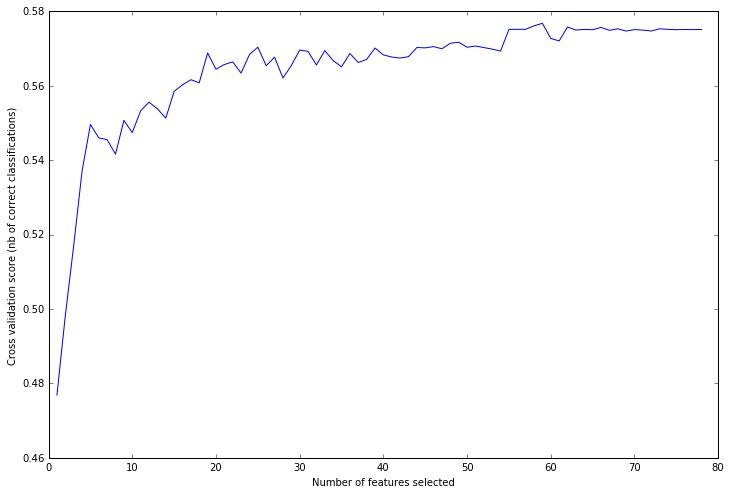

In [112]:
#Feature Selection

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[predictors_with_new_vars]
y = train_data[target_var]

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=GradientBoostingClassifier(n_estimators=100, random_state=42), step=1, cv=StratifiedKFold(y, 2),
              scoring='roc_auc', verbose=2)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

results = sorted(zip(predictors, rfecv.support_, rfecv.ranking_), key= lambda x: x[2])

#print('\r\n'.join([str(r) for r in results]))

column_filter = zip(train_data[predictors].columns, rfecv.support_)
selected_columns = [col[0] for col in column_filter if col[1]]
X = train_data[selected_columns]

In [114]:
#Reducción de features

classifiers = [
               ('rfc', RandomForestClassifier(n_estimators = 100, 
                                              random_state = 42, 
                                              class_weight = 'balanced', 
                                              min_samples_split=128, 
                                              min_samples_leaf=16)),
               ('abc', AdaBoostClassifier(n_estimators = 100, 
                                          random_state = 42, 
                                          learning_rate= 0.8)),
               ('gbc', GradientBoostingClassifier(n_estimators = 100, 
                                                  random_state = 42, 
                                                  max_features=0.3, 
                                                  min_samples_split=32, 
                                                  min_samples_leaf=16)),
              ]

params = [{'vtc__voting': ['soft']}]
preliminary_steps = []

clf = VotingClassifier(estimators=classifiers)
grids = grid_search_multiple(train_data[selected_columns], train_data[target_var], 
                     algorithms=[[('vtc', clf)]], parameters=params, preliminary_steps=preliminary_steps,
                     cv=StratifiedShuffleSplit(train_data[target_var], n_iter=6, test_size=0.2),
                     n_jobs=-2,
                     verbose=1)

Now testing vtc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:   38.6s finished


Fitting completed
Best parameters set found on development set:
{'vtc__voting': 'soft'}
Best score set found on development set:
0.647591593285
Grid scores on development set:

0.648 (+/-0.017) for {'vtc__voting': 'soft'}



In [115]:
#parámetros del mejor classifier

classifiers = [
               ('rfc', RandomForestClassifier(n_estimators = 700, 
                                              random_state = 42, 
                                              class_weight = 'balanced', 
                                              min_samples_split=128, 
                                              min_samples_leaf=16)),
               ('abc', AdaBoostClassifier(n_estimators = 500, 
                                          random_state = 42, 
                                          learning_rate= 0.7)),
               ('gbc', GradientBoostingClassifier(n_estimators = 500, 
                                                  random_state = 42, 
                                                  max_features=0.3, 
                                                  min_samples_split=32, 
                                                  min_samples_leaf=16,
                                                  learning_rate=0.07)),
              ]

params = [{'vtc__voting': ['soft']}]
preliminary_steps = []

clf = VotingClassifier(estimators=classifiers)
grids = grid_search_multiple(train_data[predictors_with_new_vars], train_data[target_var], 
                     algorithms=[[('vtc', clf)]], parameters=params, preliminary_steps=preliminary_steps,
                     cv=StratifiedShuffleSplit(train_data[target_var], n_iter=6, test_size=0.2),
                     n_jobs=-2,
                     verbose=1)

Now testing vtc
Preparing to fit
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:  3.4min finished


Fitting completed
Best parameters set found on development set:
{'vtc__voting': 'soft'}
Best score set found on development set:
0.645246858892
Grid scores on development set:

0.645 (+/-0.025) for {'vtc__voting': 'soft'}



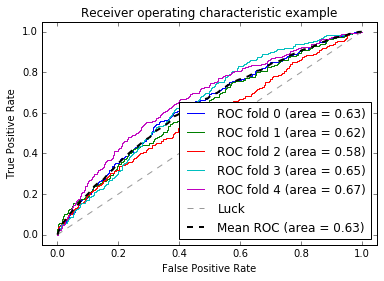

In [118]:
%matplotlib inline

from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp

X = train_data[selected_columns]
y = train_data[target_var]

cv = StratifiedKFold(y, n_folds=5)
classifier = VotingClassifier(estimators=classifiers, voting='soft')

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

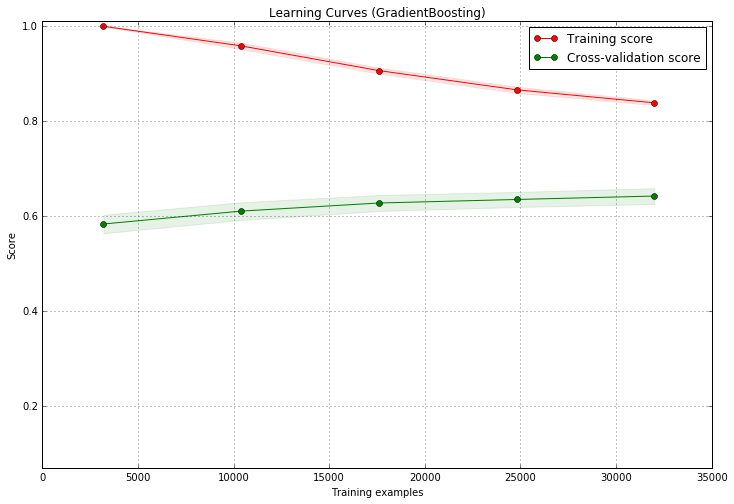

In [121]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import GradientBoostingClassifier


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X = train_data[selected_columns]
y = train_data[target_var]

title = "Learning Curves (GradientBoosting)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
estimator = GradientBoostingClassifier(n_estimators=200)
plot_learning_curve(estimator, title, X, y, (0.07, 1.01), cv=cv, n_jobs=-2)

plt.show()

[2, 4, 6, 8, 10, 12, 14]


[Parallel(n_jobs=-2)]: Done  35 out of  35 | elapsed: 12.4min finished


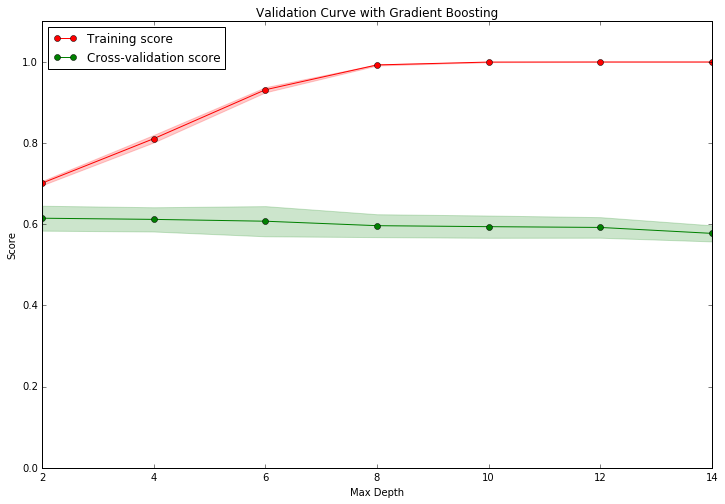

In [122]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[selected_columns]
y = train_data[target_var]

param_range = list(range(2, 16, 2))
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=64), X, y, param_name="max_depth", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[   4    8   16   32   64  128  256  512 1024 2048]


[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:  2.8min finished


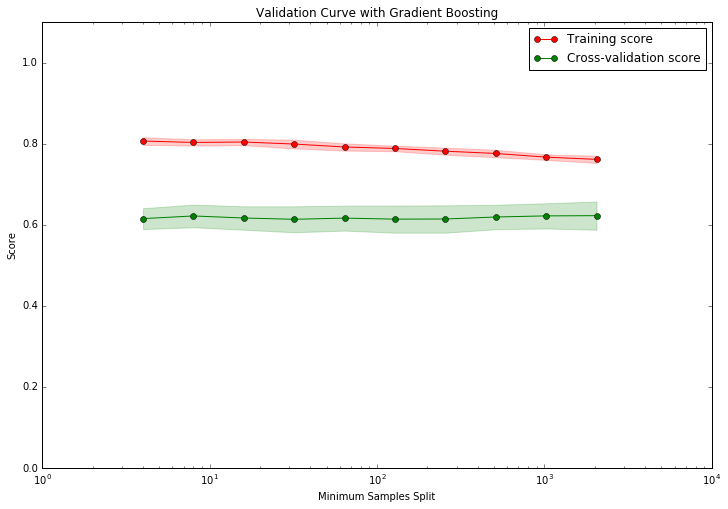

In [123]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[selected_columns]
y = train_data[target_var]

param_range = np.logspace(2, 11, 10, base=2).astype('int')
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=64, max_depth=4), X, y, param_name="min_samples_split", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Minimum Samples Split")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[1, 11, 21, 31, 41, 51, 61, 71]


[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:  2.4min finished


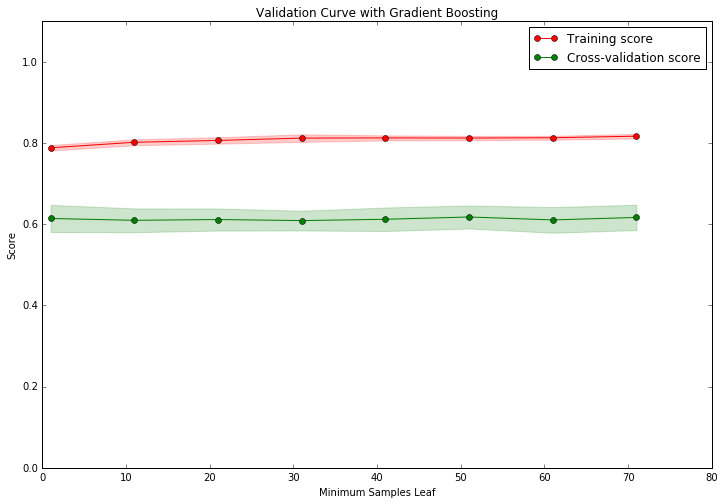

In [124]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[selected_columns]
y = train_data[target_var]

param_range = list(range(1, 72, 10))
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=64, max_depth=4, min_samples_split=128), X, y, param_name="min_samples_leaf", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Minimum Samples Leaf")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[6, 8, 10, 12, 14, 16, 18]


[Parallel(n_jobs=-2)]: Done  35 out of  35 | elapsed:   41.6s finished


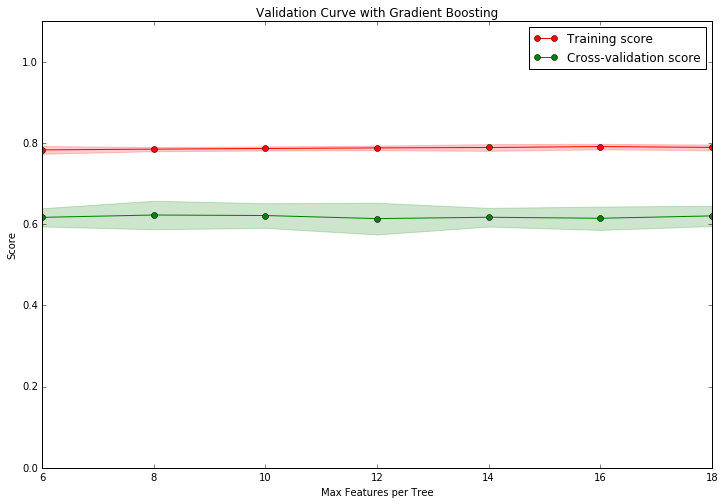

In [125]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[selected_columns]
y = train_data[target_var]

param_range = list(range(6, 20, 2))
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=64, max_depth=4, min_samples_split=128), X, y, param_name="max_features", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Max Features per Tree")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[ 0.0078125  0.015625   0.03125    0.0625     0.125      0.25       0.5        1.
  2.       ]


[Parallel(n_jobs=-2)]: Done  45 out of  45 | elapsed:  8.6min finished


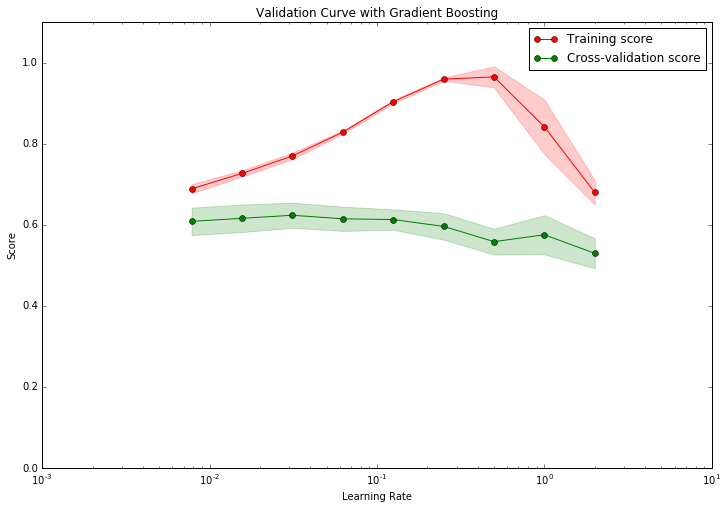

In [126]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[selected_columns]
y = train_data[target_var]

param_range = np.logspace(-7, 1, 9, base=2)
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators=300), X, y, param_name="learning_rate", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[  4   8  16  32  64 128 256 512]


[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:  3.6min finished


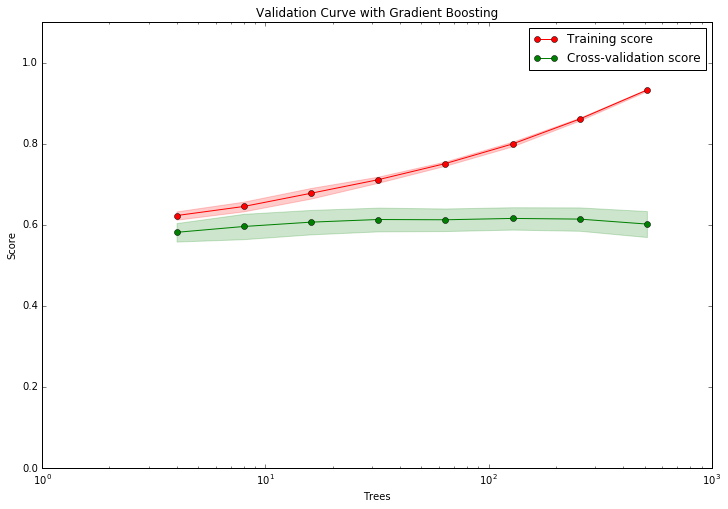

In [127]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[selected_columns]
y = train_data[target_var]

param_range = np.logspace(2, 9, 8, base=2).astype('int')
print(param_range)
train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(), X, y, param_name="n_estimators", param_range=param_range,
    cv=5, scoring="roc_auc", n_jobs=-2, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Trees")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, 'o-', label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, 'o-', label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

X = train_data[selected_columns]
y = train_data[target_var]

classifiers = [
               ('rfc', RandomForestClassifier(n_estimators = 700, 
                                              random_state = 42, 
                                              class_weight = 'balanced', 
                                              min_samples_split=128, 
                                              min_samples_leaf=16)),
               ('abc', AdaBoostClassifier(n_estimators = 500, 
                                          random_state = 42, 
                                          learning_rate= 0.7)),
               ('gbc', GradientBoostingClassifier(n_estimators = 500, 
                                                  random_state = 42, 
                                                  max_features=0.3, 
                                                  min_samples_split=32, 
                                                  min_samples_leaf=16,
                                                  learning_rate=0.07)),
              ]

clf = VotingClassifier(estimators=classifiers, voting='soft')
clf.fit(X, y)

predictions = clf.predict_proba(test_data[predictors].astype(float))
predictionsdf = pd.DataFrame(data = predictions[:, 1],
                             index = test_data["customer"],
                             columns = ["churn"])
predictionsdf.to_csv("data/predictions.csv")